# Bài tập sklearn-pipeline

Import các package cần thiết:




In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

1. Thống kê mô tả và vẽ biểu đồ phân phối trên các trường của tập dữ liệu này. Đánh giá sơ bộ về tính chất phân phối của các biến.



In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/phamdinhkhanh/datasets/master/insurance.csv', header=0, sep=',')
print(df.shape)
df.sample(5)

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
183,44,female,26.410,0,no,northwest,7419.47790
1091,55,female,29.830,0,no,northeast,11286.53870
193,56,female,26.600,1,no,northwest,12044.34200
316,50,male,32.205,0,no,northwest,8835.26495
766,47,male,32.300,1,no,southwest,8062.76400


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# Đơn vị của charges quá cao, chúng ta có thể chia 1000 để chuyển từ $ sang đơn vị nghìn $
df['charges'] /= 1000
# x = x/10 <-> x /= 10

* Bộ dữ liệu có gồm các biến đầu vào:

    * age age in years

    * sex

    * bmi body mass index

    * children

    * smoker

    * region

* Biến mục tiêu: charges (phí bảo hiểm).

number of numeric field:  4


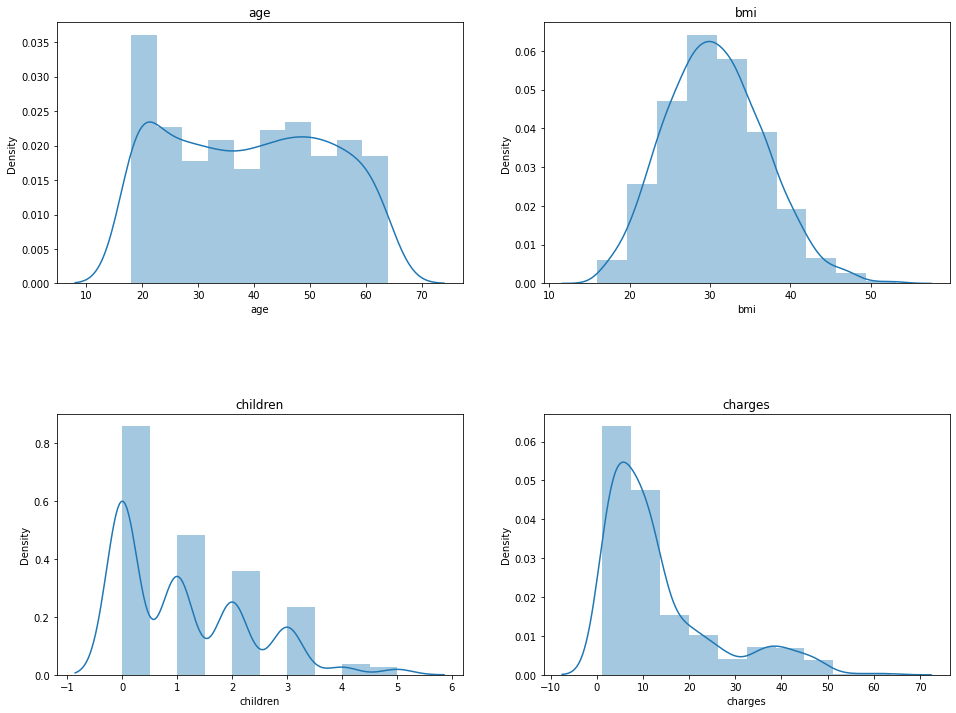

In [ ]:
# visualization
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

numeric_cols = df.select_dtypes(include=['float','int']).columns

def _plot_numeric_classes(df, col, bins=10, hist=True, kde=True):
    sns.distplot(df[col],
                 bins = bins,
                 hist = hist,
                 kde = kde)

def _distribution_numeric(df, numeric_cols, row=3, col=3, figsize=(16, 12), bins = 10):
    '''
    numeric_cols: list các tên cột
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    bins: số lượng bins phân chia trong biểu đồ distribution
    '''
    print('number of numeric field: ', len(numeric_cols))
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(df, numeric_cols[i-1], bins = bins)
        plt.title(numeric_cols[i-1])
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break

_distribution_numeric(df, numeric_cols, row=2, col=2)

number of category field:  3


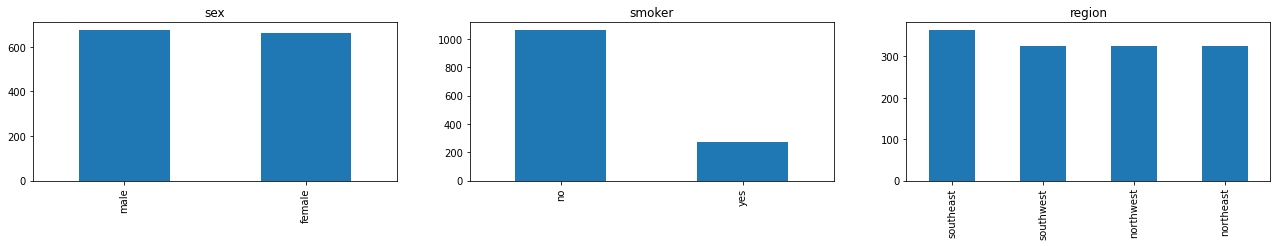

In [ ]:
cate_cols = df.select_dtypes('O').columns

def _plot_bar_classes(df, cols):
    df[cols].value_counts().plot.bar()

def _distribution_cate(df, cate_cols, row = 1, col = 2, figsize = (24, 8)):
  '''
  cate_cols: list các tên cột
  row: số lượng dòng trong lưới đồ thị
  col: số lượng cột trong lưới đồ thị
  figsize: kích thước biểu đồ
  '''
  print('number of category field: ', len(cate_cols))
  plt.figure(figsize = figsize)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)    
  for i in range(1, len(cate_cols)+1, 1):
    try:
      plt.subplot(row, col, i)
      _plot_bar_classes(df, cate_cols[i-1])
      plt.title(cate_cols[i-1])
    except:
      break

_distribution_cate(df, cate_cols, row = 4, col = 4, figsize = (30, 16))

Text(0.5, 1.0, 'Boxplot of Dimensions')

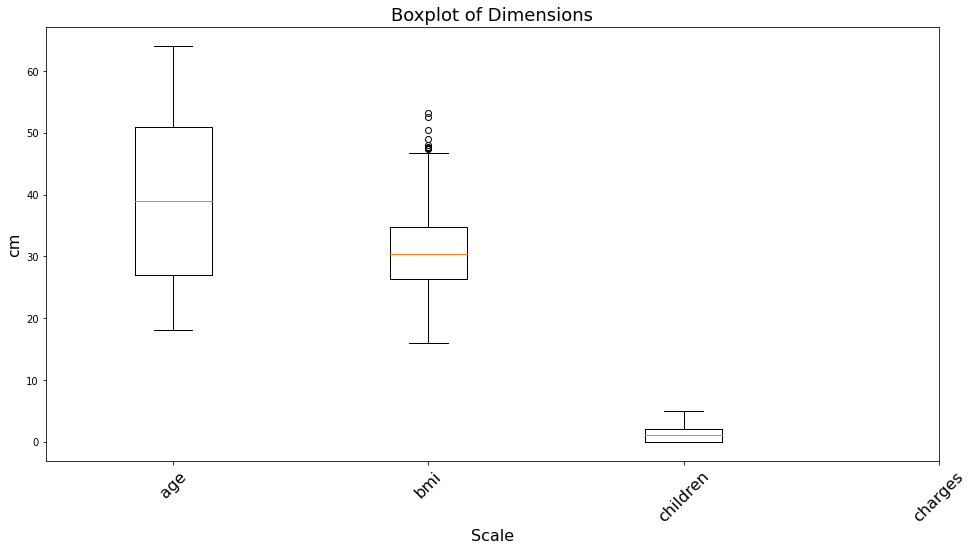

In [ ]:
# Vẽ biểu đồ bboxplot
plt.figure(figsize=(16, 8))
plt.boxplot([df[col] for col in numeric_cols if col != 'charges'])
plt.xlabel('Scale', fontsize=16)
plt.ylabel('cm', fontsize=16)
plt.xticks(np.arange(len(numeric_cols))+1, numeric_cols, rotation=45, fontsize=16)
plt.title("Boxplot of Dimensions", fontsize=18)

Text(0.5, 1.0, 'Target distribution')

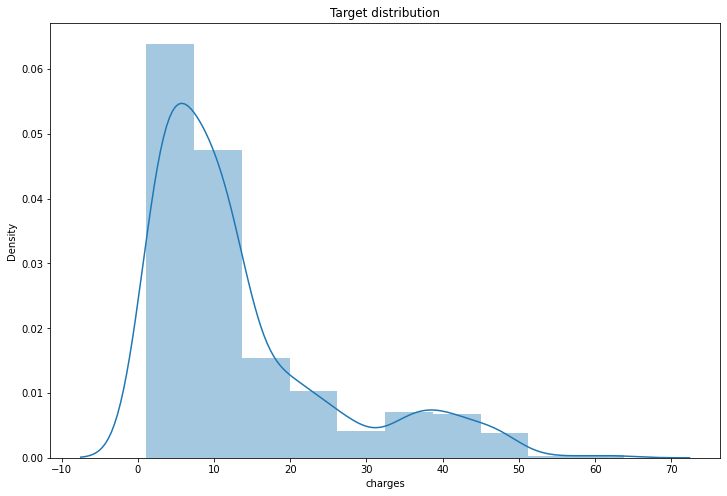

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(df['charges'],
            bins = 10,
            hist = True,
            kde = True)
plt.title('Target distribution')

2. Hãy tạo thành một pipeline hoàn chỉnh để xử lý dữ liệu từ thô sang tinh.


In [ ]:
# Pipeline xử lý cho biến phân loại
cat_pl= Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # Xử lý missing data bằng cách thay thế most frequent
        ('onehot', OneHotEncoder()), # Biến đổi giá trị của biến phân loại thành véc tơ OneHot
    ]
)

# Pipeline xử lý cho biến liên tục
num_pl = Pipeline(
    steps=[
           ('imputer', KNNImputer(n_neighbors=7)), # Xử lý missing data bằng cách dự báo KNN với n=7.
           ('scaler', MinMaxScaler()) # Xử lý missing data bằng MinMax scaler
    ]
)

In [ ]:
from sklearn.compose import ColumnTransformer

# Bỏ biến mục tiêu ra khỏi num_names
numeric_cols_ = [col for col in numeric_cols if col != 'charges']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pl, numeric_cols_), # áp dụng pipeline cho biến liên tục
        ('cat', cat_pl, cate_cols), # áp dụng pipeline cho biến phân loại
    ]
)


3. Phân chia tập train/test và lựa chọn metric cho bài toán.




In [ ]:
# Cách 1: dùng train_test_split()
df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape, df_test.shape)

(1070, 7) (268, 7)


In [ ]:
# Cách 2: sử dụng np.random.shuffle(np.arange())
idx = np.arange(df.shape[0])
np.random.shuffle(idx)
cut_idx = int(len(idx)*0.8)

idx_train = idx[:cut_idx]
idx_test  = [id for id in idx if id not in idx_train]

df_train, df_test = df.loc[idx_train, :], df.loc[idx_test, :]
print(df_train.shape, df_test.shape)

(1070, 7) (268, 7)


In [ ]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

X_train, y_train = df_train[input_cols], df_train['charges']
X_test, y_test = df_test[input_cols], df_test['charges']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1070, 6) (1070,)
(268, 6) (268,)



4. Lựa chọn một lớp mô hình phù hợp, thực hiện cross validation để huấn luyện và đánh giá mô hình đó trên tập train.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedKFold

# Completed training pipeline
completed_pl = Pipeline(
    steps=[
            ("preprocessor", preprocessor), 
            ("regressor", LinearRegression())
    ]
)

# Xác định KFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
# Xác định metrics
def f_mse(y, y_pred):
  mse = np.sqrt(np.mean((y-y_pred)**2))
  return mse

metric = make_scorer(f_mse)

In [ ]:
all_scores = []

scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
all_scores.append(scores)

print('mse mean: {:.2f}, mse std: {:.2f}'.format(np.mean(all_scores), np.std(all_scores)))

mse mean: 6.10, mse std: 0.51



5. Triển khai lại quá trình ở bài 4 trên nhiều lớp mô hình khác nhau.


In [ ]:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR

models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), SGDRegressor(), SVR()]

all_scores = []
# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
for model in models:
  completed_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('regressor', model)]
  )

  scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
  all_scores.append(scores)


6. Vẽ biểu đồ thể hiện kết quả của các mô hình và Kết luận đâu là mô hình tốt nhất.


Text(0.5, 1.0, 'Scores Metrics')

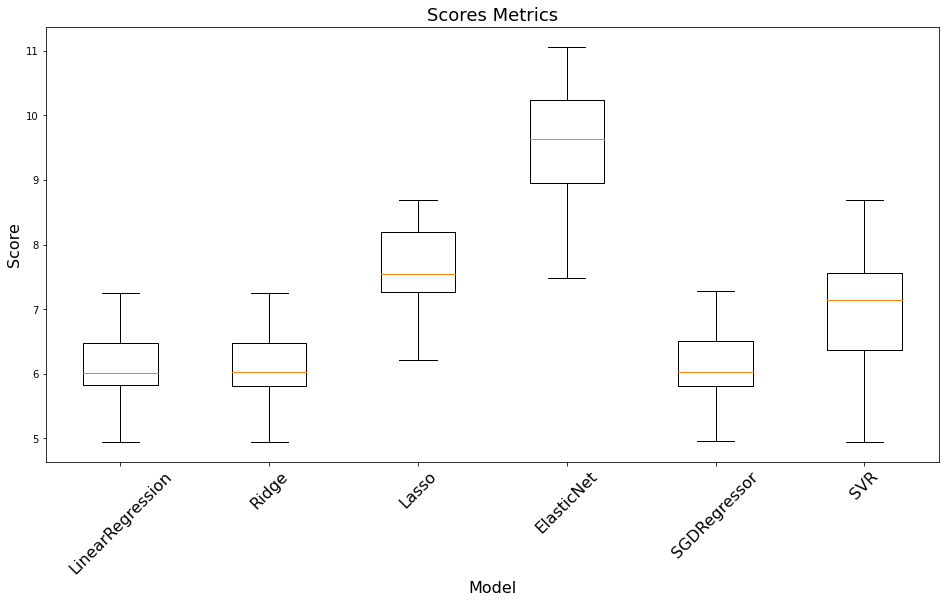

In [ ]:
import matplotlib.pyplot as plt
model_names = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SGDRegressor', 'SVR']

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

Lớp mô hình tốt nhất là LinearRegression. Chúng ta thực hiện gridsearch trên không gian tham số của nó bằng hàm GridSearchCV.


7. Dựa vào lớp mô hình tốt nhất được lựa chọn, thực hiện grid search trên không gian tham số của nó.

Trước khi thực hiện gridsearch, cần xác định các tham số của mô hình là gì?
Chúng ta nên vào document của lớp mô hình, ở đây là [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), để tìm kiếm thông tin về các tham số.

Có hai tham số chính có thể search đó là:

`fit_intercept`: có hệ số chặn hay không và `normalize`: có thực hiện chuẩn hoá biến đầu vào trước khi hồi qui mô hình hay không. 

In [ ]:

from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(
    steps=[("pre", preprocessor), ("regressor", LinearRegression())]
)

In [ ]:
parameters = [
  {
    'regressor__fit_intercept': (True, False), # SVM if hinge loss / logreg if log loss
    'regressor__normalize': (True, False)
  }
]

In [ ]:
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, scoring=metric, return_train_score=True, error_score=0, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   4 out of  20 | elapsed:    4.8s remaining:   19.1s
[Parallel(n_jobs=12)]: Done  11 out of  20 | elapsed:    5.4s remaining:    4.4s
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    7.9s remaining:    0.9s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    8.0s finished


GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(memory=None,
                                steps=[('pre',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          KNNImputer(add_indicator=False,
                                                                                                     copy=True,
                                                     

In [ ]:
gscv.best_estimator_

Pipeline(memory=None,
         steps=[('pre',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   KNNImputer(add_indicator=False,
                                                                              copy=True,
                                                                              metric='nan_euclidean',
                                                                              missing_values=nan,
                                                                              n_neighbors=7,
                                                                              weig

In [ ]:
gscv.best_params_

{'regressor__fit_intercept': True, 'regressor__normalize': False}